```
SOW-MKI95 Computer Graphics & Computer Vision
Generative adversarial networks
```

```
Group number: 5 
Frederike  s1060943
Steffen    s1009136
Ron        s1000522
```

In this lab, you will reimplement the DCGAN from the Gluon tutorial, convert it to a WGAN and compare their results after training them on different datasets.

### Task 1 (33 points):

Reimplement the DCGAN from the Gluon tutorial in this notebook. You can find the Gluon tutorial [here](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html).

In [49]:
from __future__ import print_function
import os
import tarfile
from datetime import datetime
import time
import logging

!pip install mxnet-cu100
import mxnet as mx
from mxnet import autograd, nd, gluon
from mxnet.gluon import nn, utils

import numpy as np

import tqdm.notebook as tqdm

import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline


### Set the Training Parameters

In [50]:
# General Parameters

batch_size = 64
latent_z_size = 100

ctx = mx.gpu()
learning_rate = 0.00005 if wgan else 0.0002
beta1 = 0.5
clip_gradient = 0.01

### Data

In [51]:
# Download the data
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [52]:
# Resize the images to 64 x 64 and normalize to [-1,1]
def transform(data, label=None):
    
    target_wd = 64
    target_ht = 64

    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    
    # transpose from (target_wd, target_ht, 3) to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape), label

# Transform the data
img_list = []
for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr, _ = transform(img_arr)
        img_list.append(img_arr)

# Create the train data iterator
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

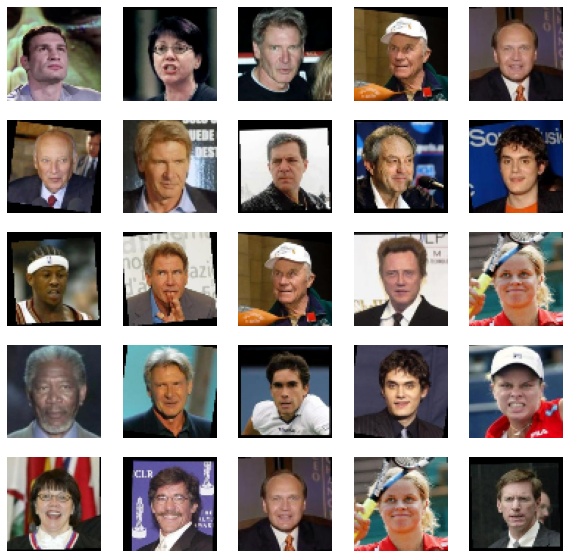

In [53]:
# Visualize some images

def visualize(ax, image):
    ax.imshow(((image.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    ax.axis('off')


def plot_real(img_list):
    fig, ax = plt.subplots(5,5, figsize=(10,10))
    for i in range(5):
        for j in range(5):
            visualize(ax[i, j], img_list[(i+10) * (j+3)][0])
    plt.show()



# Plotting real images
plot_real(img_list)

## Defining the networks

In [54]:
class Generator(nn.HybridSequential):
    def __init__(self, n_features=64, n_channels=3, **kwargs):
        super(Generator, self).__init__(**kwargs)
        with self.name_scope():

            # Input Z (size 100) to convolution, sequentially getting larger
            # state size output: (n_features * 8) x 4 x 4
            self.add(nn.Conv2DTranspose(channels=n_features * 8, kernel_size=4, strides=1, padding=0, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))

            # state size output: (n_features * 4) x 8 x 8
            self.add(nn.Conv2DTranspose(channels=n_features * 4, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))

            # state size output: (n_features * 2) x 16 x 16
            self.add(nn.Conv2DTranspose(channels=n_features * 2, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))

            # state size output: (n_features) x 32 x 32
            self.add(nn.Conv2DTranspose(channels=n_features, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))

            # state size output: (n_channels) x 64 x 64
            self.add(nn.Conv2DTranspose(channels=n_channels, kernel_size=4, strides=2, padding=1, use_bias=False))
            # self.add(nn.BatchNorm())
            self.add(nn.Activation('tanh'))

In [55]:
class Discriminator(nn.HybridSequential):
    def __init__(self, n_features=64, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        
        # Input is n_channels x 64 x 64
        # state size output: (n_features) x 32 x 32
        self.add(nn.Conv2D(channels=n_features, kernel_size=4, strides=2, padding=1, use_bias=False))
        # self.add(nn.BatchNorm())
        self.add(nn.LeakyReLU(0.2))

        # state size output: (n_features * 2) x 16 x 16
        self.add(nn.Conv2D(channels=n_features * 2, kernel_size=4, strides=2, padding=1, use_bias=False))
        self.add(nn.BatchNorm())
        self.add(nn.LeakyReLU(0.2))
        
        # state size output: (n_features * 4) x 8 x 8
        self.add(nn.Conv2D(channels=n_features * 4, kernel_size=4, strides=2, padding=1, use_bias=False))
        self.add(nn.BatchNorm())
        self.add(nn.LeakyReLU(0.2))

        # state size output: (n_features * 8) x 4 x 4
        self.add(nn.Conv2D(channels=n_features * 8, kernel_size=4, strides=2, padding=1, use_bias=False))
        self.add(nn.BatchNorm())
        self.add(nn.LeakyReLU(0.2))

        # state size output: (n_channels) x 4 x 4
        self.add(nn.Conv2D(channels=1, kernel_size=4, strides=1, padding=0, use_bias=False))

### Setup Loss Function and Optimizer

In [56]:
def initialize(wgan): 

    # Initialize networks
    generator = Generator()
    generator.initialize(mx.init.Normal(0.02), ctx=ctx)
    generator.hybridize()

    discriminator = Discriminator()
    discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)
    discriminator.hybridize()

    # Trainers
    trainerG = gluon.Trainer(
        generator.collect_params(), 
        'rmsprop', 
       {'learning_rate': learning_rate}) if wgan else gluon.Trainer(generator.collect_params(), 
        'adam', 
       {'learning_rate': learning_rate, 
        'beta1': beta1}
       )
    trainerD = gluon.Trainer(
        discriminator.collect_params(), 
        'rmsprop', 
        {'learning_rate': learning_rate, 
         'clip_weights': clip_gradient}) if wgan else gluon.Trainer(discriminator.collect_params(), 
         'adam', 
        {'learning_rate': learning_rate, 
         'beta1': beta1}
        )

    return generator, discriminator, trainerG, trainerD


## Training Loop DCGAN

In [57]:
def train_DCGAN(train_data, generator, discriminator, trainerG, trainerD, epochs=10):

    loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
    metric = mx.metric.Accuracy()

    fake_label = nd.zeros((batch_size,),ctx=ctx)
    real_label = nd.ones((batch_size,), ctx=ctx)

    loss_G = []
    loss_D = []
    print_period = 10

    for epoch in tqdm.tqdm(range(epochs), desc='epochs'):
        
        start = time.time()
        train_data.reset()
        epoch_loss_G = 0
        epoch_loss_D = 0
        n_batch = 0

        for batch in train_data:
            n_batch += 1
            
            ###########################################
            #  Update Discriminator network:          #
            #  maximize log(D(x)) + log(1 - D(G(z)))  #
            ###########################################     

            data = batch.data[0].as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
            
            with autograd.record():

                # train with real image
                output = discriminator(data).reshape((-1, 1))
                errD_real = loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = generator(latent_z)
                output = discriminator(fake.detach()).reshape((-1, 1))
                errD_fake = loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainerD.step(batch.data[0].shape[0])
            epoch_loss_D += nd.mean(errD).asscalar()

            ###############################
            #  Update Generator network:  #
            #  maximize log(D(G(z)))      #
            ###############################

            with autograd.record():
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errG = loss(output, real_label)
                errG.backward()

            trainerG.step(batch.data[0].shape[0])
            epoch_loss_G += nd.mean(errG).asscalar()

            if n_batch % 50 == 0:
              visualize(plt, fake[0])
              plt.show()

        epoch_loss_G /= n_batch
        epoch_loss_D /= n_batch

        loss_G.append(epoch_loss_G)
        loss_D.append(epoch_loss_D)

        name, acc = metric.get()
        metric.reset()
        
        print(f'Epoch {epoch}, Accuracy = {acc:.2f}, Generator loss = {epoch_loss_G:.2f}, Discriminator loss = {epoch_loss_D:.2f}')

        visualize(plt, fake[0])
        plt.show()

    end = time.time()
    print(f'Time elapsed: {end - start:.2f}s')

    plt.plot(loss_G, label='Generator loss')
    plt.plot(loss_D, label='Discriminator loss')
    plt.legend()
    plt.show()

In [ ]:
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
train_DCGAN(train_data, generator, discriminator, trainerG, trainerD, epochs=10)

In [22]:
# Saving the network parameters
generator.save_parameters('DCGAN_generator.params')
discriminator.save_parameters('DCGAN_discriminator.params')

In [58]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
generator.load_parameters('DCGAN_generator.params')
discriminator.load_parameters('DCGAN_discriminator.params')

### Results

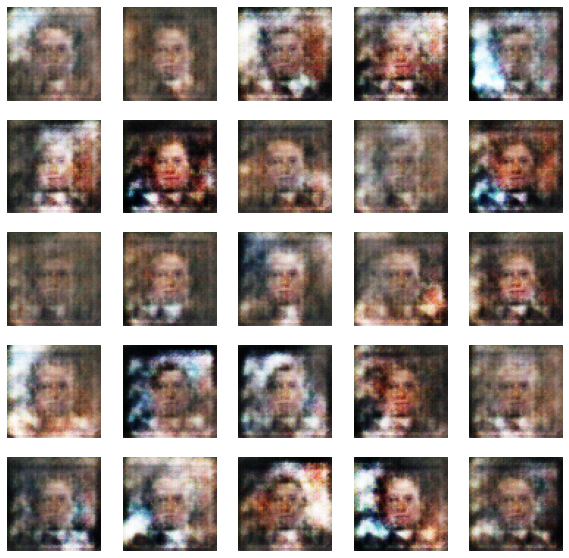

In [59]:
def plot_some_fakes(generator):
    fig, ax = plt.subplots(5,5, figsize=(10,10))
    for i in range(5):
        for j in range(5):
            latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
            img = generator(latent_z)
            visualize(ax[i, j], img[0])
    plt.show()


# Plotting DCGAN generated images
plot_some_fakes(generator)

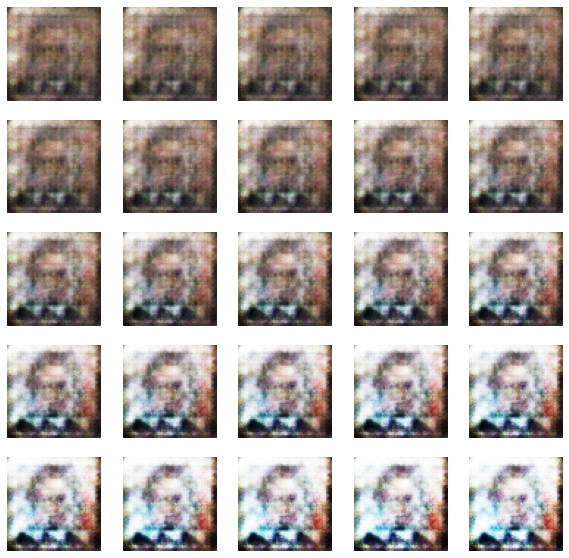

In [60]:
def plot_across_latent(generator):
    fig, ax = plt.subplots(5,5, figsize=(10,10))
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    step = 0.05
    for i in range(5):
        for j in range(5):
            img = generator(latent_z)
            visualize(ax[i, j], img[0])
            latent_z += 0.05
    plt.show()


# Plotting across latent space
plot_across_latent(generator)

### Task 2 (33 points):

Convert the DCGAN to a WGAN.

You can refer to [the WGAN paper](https://arxiv.org/abs/1701.07875) and/or the below notes.

The paper introduces a new loss function for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN.

#### Loss

Let’s compare the binary cross-entropy loss function (the function that that we are currently using to train the discriminator and generator of the DCGAN) to the Wasserstein loss function.

First, the Wasserstein loss requires that we use yi=1 and yi=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

$$-\frac{1}{n} \sum_{i=1}^{n}\left(y_{i} p_{i}\right)$$

To train the WGAN critic D, we calculate the loss when comparing predictions for a real images pi=D(xi) to the response yi=1 and predictions for generated images pi=D(G(zi)) to the response yi=-1. Therefore for the WGAN critic, minimizing the loss function can be written as follows:

$$\min _{D}-\left(\mathbb{E}_{x \sim p_{X}}[D(x)]-\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

In other words, the WGAN critic tries to maximise the difference between its predictions for real images and generated images, with real images scoring higher. To train the WGAN generator, we calculate the loss when comparing predictions for generated images pi=D(G(zi)) to the response yi=1. Therefore for the WGAN generator, minimizing the loss function can be written as follows:

$$\min _{G}-\left(\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

#### Constraints

For the Wasserstein loss function to work, we also need to place an additional constraint on the critic. Specifically, it is required that the critic is a 1-Lipschitz continuous function. Let’s pick this apart to understand what it means in more detail. The critic is a function D that converts an image into a prediction. We say that this function is 1-Lipschitz if it satisfies the following inequality for any two input images, \( x_1 \) and \( x_2 \):

$$ \vert\frac{D(x_1)-D(x_2)\vert}{\vert x_1-x_2\vert}\leq1 $$

Essentially, we require a limit on the rate at which the predictions of the critic can change between two images (i.e., the absolute value of the gradient must be at most 1 everywhere).

It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

#### Training

When using the Wasserstein loss function, we should train the critic to convergence to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the discriminator get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

## Training Loop WGAN

In [61]:
def train_WGAN(train_data, generator, discriminator, trainerG, trainerD, epochs=10):

    metric = mx.metric.Accuracy()

    n_critic = 5
    fake_label = -1 * nd.ones((batch_size,), ctx=ctx)
    real_label = nd.ones((batch_size,), ctx=ctx)

    loss_G = []
    loss_D = []

    print_period = 10

    for epoch in tqdm.tqdm(range(epochs), desc='epochs'):
        
        start = time.time()
        train_data.reset()
        epoch_loss_G = 0
        epoch_loss_D = 0
        n_batch = 0

        for batch in train_data:

            ###################################
            #  Update Discriminator network:  #
            #  min_D -(E[D(x)] - E[D(G(z))])  #
            ###################################
            for _ in range(n_critic):
                n_batch += 1
                
                # Sample
                data = batch.data[0].as_in_context(ctx)
                latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
                    
                with autograd.record():

                    # Real data and discriminate
                    output = discriminator(data).reshape((-1, 1))
                    errD_real = nd.mean(output)
                    
                    # Accuracy of discriminator
                    metric.update([real_label,], [output,])
                    
                    # Create fake data and discriminate
                    fake = generator(latent_z)                
                    output = discriminator(fake.detach()).reshape((-1, 1))
                    errD_fake = nd.mean(output)
                    errD = -(errD_real - errD_fake)
                    errD.backward()
                    
                    # Accuracy of generator
                    metric.update([fake_label,], [output,])

                trainerD.step(batch.data[0].shape[0])
                epoch_loss_D += nd.mean(errD).asscalar()


                ###############################
                #  Update Generator network:  #
                #  min_G -E[D(G(z))]          #
                ###############################
                
                latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
                with autograd.record():
                    fake = generator(latent_z)
                    output = discriminator(fake).reshape((-1, 1))
                    errG = -nd.mean(output)
                    errG.backward()

                trainerG.step(batch.data[0].shape[0])
                epoch_loss_G += nd.mean(errG).asscalar()

                if n_batch % 50 == 0:
                    visualize(plt, fake[0])
                    plt.show()

        epoch_loss_G /= n_batch
        epoch_loss_D /= n_batch

        loss_G.append(epoch_loss_G)
        loss_D.append(epoch_loss_D)

        name, acc = metric.get()
        metric.reset()
        
        print(f'Epoch {epoch}, {name} = {acc:.2f}, Generator loss = {epoch_loss_G:.2f}, Discriminator loss = {epoch_loss_D:.2f}')
        
        # Show an image
        visualize(plt, fake[0])
        plt.show()

    end = time.time()
    print(f'Time elapsed: {end - start:.2f}s')

    plt.plot(loss_G, label='Generator loss')
    plt.plot(loss_D, label='Discriminator loss')
    plt.legend()
    plt.show()

In [ ]:
generator, discriminator, trainerG, trainerD = initialize(wgan=True)
train_WGAN(train_data, generator, discriminator, trainerG, trainerD, epochs=10)

In [ ]:
# Saving the network parameters
generator.save_parameters('WGAN_generator.params')
discriminator.save_parameters('WGAN_discriminator.params')

In [62]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=True)
generator.load_parameters('WGAN_generator.params')
discriminator.load_parameters('WGAN_discriminator.params')

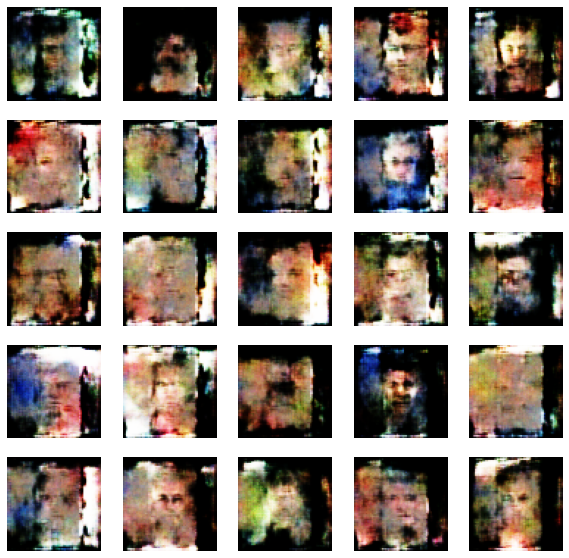

In [63]:
# Plotting WGAN generated images
plot_some_fakes(generator)

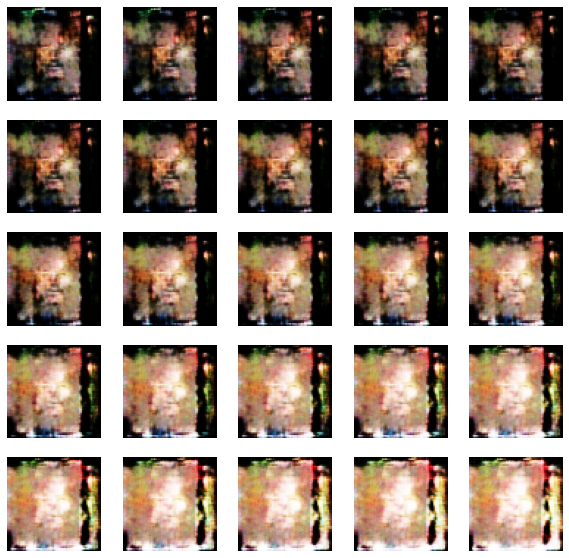

In [64]:
plot_across_latent(generator)

### Task 3 (33 points):

Compare their results of the DCGAN and the WGAN after training them on different datasets (at least three). You are free to select which datasets to use (it would be easier if you use relatively small datasets). For example, you can use MNIST and Fashion-MNIST datasets (available from Gluon) or anime characters and pokemons datasets (several versions can be found on GitHub).

## Fashion MNIST

In [80]:
def train_DCGAN_MNIST(train_data_loader, generator, discriminator, trainerG, trainerD, epochs=10):

    loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
    metric = mx.metric.Accuracy()

    fake_label = nd.zeros((batch_size,),ctx=ctx)
    real_label = nd.ones((batch_size,), ctx=ctx)

    loss_G = []
    loss_D = []
    print_period = 10

    for epoch in tqdm.tqdm(range(epochs), desc='epochs'):
        
        start = time.time()
        epoch_loss_G = 0
        epoch_loss_D = 0
        n_batch = 0

        for batch, _ in train_data_loader:
            if batch.shape[0] == 64:
              n_batch += 1
              
              ###########################################
              #  Update Discriminator network:          #
              #  maximize log(D(x)) + log(1 - D(G(z)))  #
              ###########################################     

              data = nd.squeeze(batch, axis=1).as_in_context(ctx)
              latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
              
              with autograd.record():

                  # train with real image
                  output = discriminator(data).reshape((-1, 1))
                  errD_real = loss(output, real_label)
                  metric.update([real_label,], [output,])

                  # train with fake image
                  fake = generator(latent_z)
                  output = discriminator(fake.detach()).reshape((-1, 1))
                  errD_fake = loss(output, fake_label)
                  errD = errD_real + errD_fake
                  errD.backward()
                  metric.update([fake_label,], [output,])

              trainerD.step(batch.shape[0])
              epoch_loss_D += nd.mean(errD).asscalar()

              ###############################
              #  Update Generator network:  #
              #  maximize log(D(G(z)))      #
              ###############################

              with autograd.record():
                  fake = generator(latent_z)
                  output = discriminator(fake).reshape((-1, 1))
                  errG = loss(output, real_label)
                  errG.backward()

              trainerG.step(batch.shape[0])
              epoch_loss_G += nd.mean(errG).asscalar()

              if n_batch % 50 == 0:
                visualize(plt, fake[0])
                plt.show()

        epoch_loss_G /= n_batch
        epoch_loss_D /= n_batch

        loss_G.append(epoch_loss_G)
        loss_D.append(epoch_loss_D)

        name, acc = metric.get()
        metric.reset()
        
        print(f'Epoch {epoch}, Accuracy = {acc:.2f}, Generator loss = {epoch_loss_G:.2f}, Discriminator loss = {epoch_loss_D:.2f}')

        visualize(plt, fake[0])
        plt.show()

    end = time.time()
    print(f'Time elapsed: {end - start:.2f}s')

    plt.plot(loss_G, label='Generator loss')
    plt.plot(loss_D, label='Discriminator loss')
    plt.legend()
    plt.show()

In [ ]:
train_dataset = mx.gluon.data.vision.datasets.FashionMNIST(train=True, transform=transform)
train_data_loader = mx.gluon.data.DataLoader(train_dataset, batch_size)
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
train_DCGAN_MNIST(train_data_loader, generator, discriminator, trainerG, trainerD, epochs=10)

In [40]:
# Saving the network parameters
generator.save_parameters('DCGAN_generator_FashionMNIST.params')
discriminator.save_parameters('DCGAN_discriminator_FashionMNIST.params')

In [66]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
generator.load_parameters('DCGAN_generator_FashionMNIST.params')
discriminator.load_parameters('DCGAN_discriminator_FashionMNIST.params')

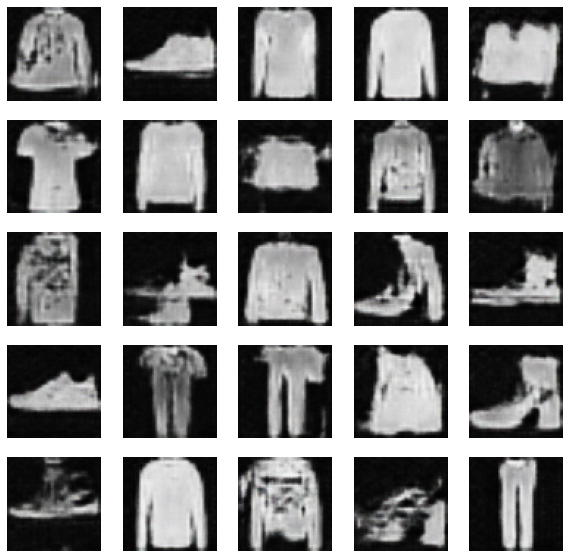

In [67]:
plot_some_fakes(generator)

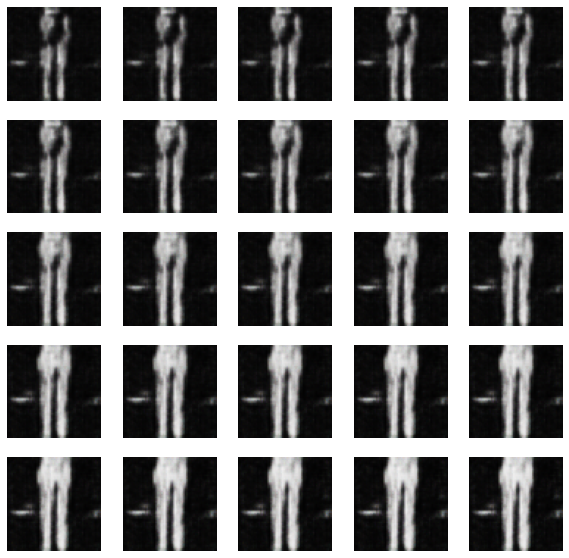

In [68]:
plot_across_latent(generator)

We can see in the two plots above that the DCGAN is able to generate FashionMNIST like images. We can clearly distinguish between different items of clothing.

In [69]:
def train_WGAN_MNIST(train_data_loader, generator, discriminator, trainerG, trainerD, epochs=10):

    metric = mx.metric.Accuracy()

    n_critic = 5
    fake_label = -1 * nd.ones((batch_size,), ctx=ctx)
    real_label = nd.ones((batch_size,), ctx=ctx)

    loss_G = []
    loss_D = []

    print_period = 10

    for epoch in tqdm.tqdm(range(epochs), desc='epochs'):
        
        start = time.time()
        epoch_loss_G = 0
        epoch_loss_D = 0
        n_batch = 0

        for batch, _ in train_data_loader:
          if batch.shape[0] == 64:

                ###################################
                #  Update Discriminator network:  #
                #  min_D -(E[D(x)] - E[D(G(z))])  #
                ###################################
                for _ in range(n_critic):
                    n_batch += 1
                    
                    # Sample
                    data = nd.squeeze(batch, axis=1).as_in_context(ctx)
                    latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
                        
                    with autograd.record():

                        # Real data and discriminate
                        output = discriminator(data).reshape((-1, 1))
                        errD_real = nd.mean(output)
                        
                        # Accuracy of discriminator
                        metric.update([real_label,], [output,])
                        
                        # Create fake data and discriminate
                        fake = generator(latent_z)                
                        output = discriminator(fake.detach()).reshape((-1, 1))
                        errD_fake = nd.mean(output)
                        errD = -(errD_real - errD_fake)
                        errD.backward()
                        
                        # Accuracy of generator
                        metric.update([fake_label,], [output,])

                    trainerD.step(data.shape[0])
                    epoch_loss_D += nd.mean(errD).asscalar()


                    ###############################
                    #  Update Generator network:  #
                    #  min_G -E[D(G(z))]          #
                    ###############################
                    
                    latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
                    with autograd.record():
                        fake = generator(latent_z)
                        output = discriminator(fake).reshape((-1, 1))
                        errG = -nd.mean(output)
                        errG.backward()

                    trainerG.step(data.shape[0])
                    epoch_loss_G += nd.mean(errG).asscalar()

                    if n_batch % 50 == 0:
                        visualize(plt, fake[0])
                        plt.show()

        epoch_loss_G /= n_batch
        epoch_loss_D /= n_batch

        loss_G.append(epoch_loss_G)
        loss_D.append(epoch_loss_D)

        name, acc = metric.get()
        metric.reset()
        
        print(f'Epoch {epoch}, {name} = {acc:.2f}, Generator loss = {epoch_loss_G:.2f}, Discriminator loss = {epoch_loss_D:.2f}')
        
        # Show an image
        visualize(plt, fake[0])
        plt.show()

    end = time.time()
    print(f'Time elapsed: {end - start:.2f}s')

    plt.plot(loss_G, label='Generator loss')
    plt.plot(loss_D, label='Discriminator loss')
    plt.legend()
    plt.show()

In [ ]:
train_dataset = mx.gluon.data.vision.datasets.FashionMNIST(train=True, transform=transform)
train_data_loader = mx.gluon.data.DataLoader(train_dataset, batch_size)
generator, discriminator, trainerG, trainerD = initialize(True)
train_WGAN_MNIST(train_data_loader, generator, discriminator, trainerG, trainerD, epochs=10)

In [ ]:
# Saving the network parameters
generator.save_parameters('WGAN_generator_FashionMNIST.params')
discriminator.save_parameters('WGAN_discriminator_FashionMNIST.params')

In [70]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
generator.load_parameters('WGAN_generator_FashionMNIST.params')
discriminator.load_parameters('WGAN_discriminator_FashionMNIST.params')

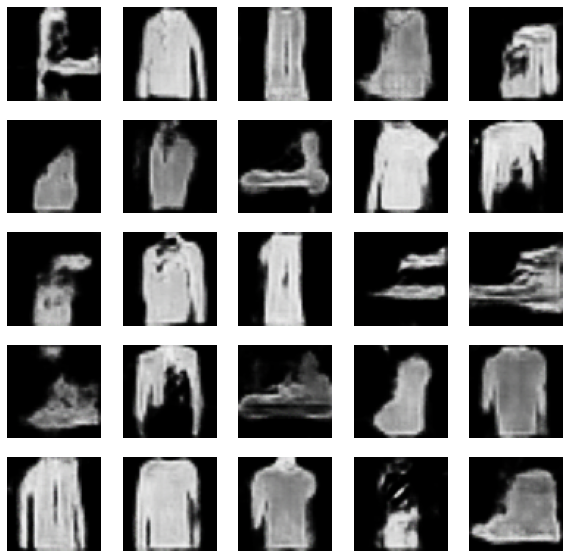

In [71]:
plot_some_fakes(generator)

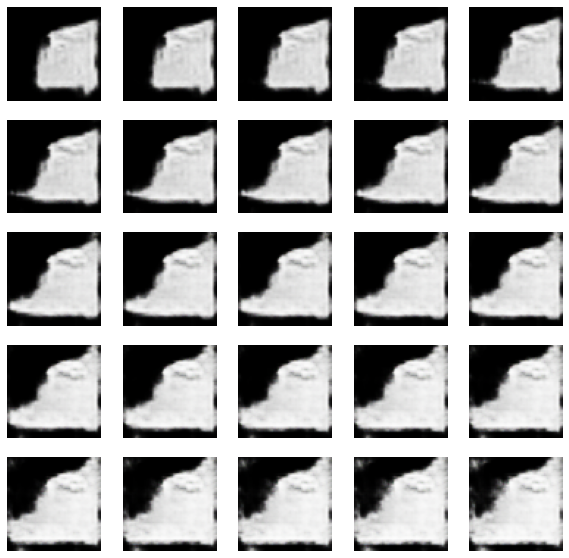

In [72]:
plot_across_latent(generator)

Here too, we see that the images generated by the WGAN are quite good. They compare pretty similarly to the images generated by the DCGAN. A clear distinction is not easily seen. This is in contrast to the first exercise in which we saw that the WGAN produces much more vibrant images. 

## MNIST

In [ ]:
train_dataset = mx.gluon.data.vision.datasets.MNIST(train=True, transform=transform)
train_data_loader = mx.gluon.data.DataLoader(train_dataset, batch_size)
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
train_DCGAN_MNIST(train_data_loader, generator, discriminator, trainerG, trainerD, epochs=10)

In [ ]:
# Saving the network parameters
generator.save_parameters('DCGAN_generator_MNIST.params')
discriminator.save_parameters('DCGAN_discriminator_MNIST.params')

In [76]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
generator.load_parameters('DCGAN_generator_MNIST.params')
discriminator.load_parameters('DCGAN_discriminator_MNIST.params')

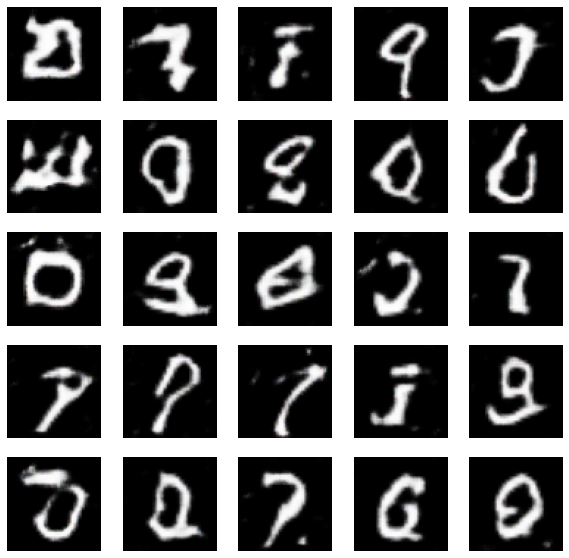

In [77]:
plot_some_fakes(generator)

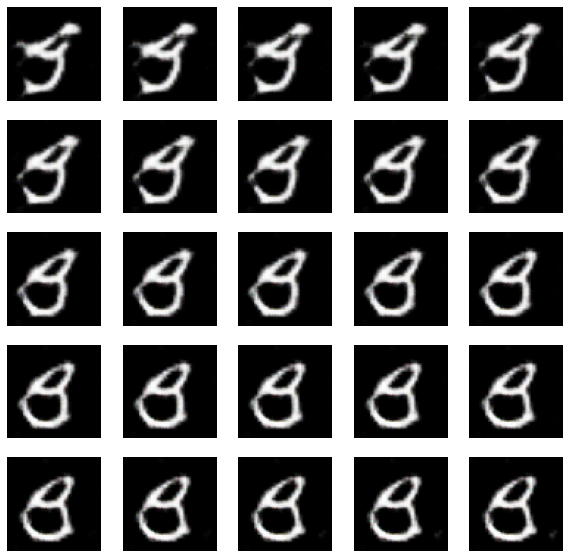

In [78]:
plot_across_latent(generator)

In [ ]:
train_dataset = mx.gluon.data.vision.datasets.MNIST(train=True, transform=transform)
train_data_loader = mx.gluon.data.DataLoader(train_dataset, batch_size)
generator, discriminator, trainerG, trainerD = initialize(True)
train_WGAN_MNIST(train_data_loader, generator, discriminator, trainerG, trainerD, epochs=10)

In [ ]:
# Saving the network parameters
generator.save_parameters('WGAN_generator_MNIST.params')
discriminator.save_parameters('WGAN_discriminator_MNIST.params')

In [83]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=True)
generator.load_parameters('WGAN_generator_MNIST.params')
discriminator.load_parameters('WGAN_discriminator_MNIST.params')

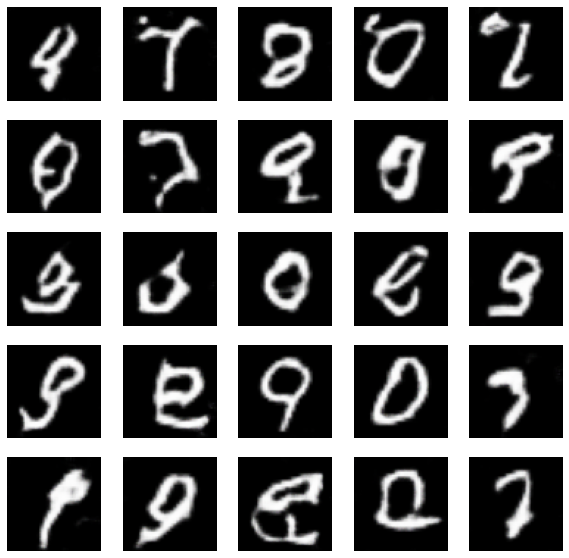

In [84]:
plot_some_fakes(generator)

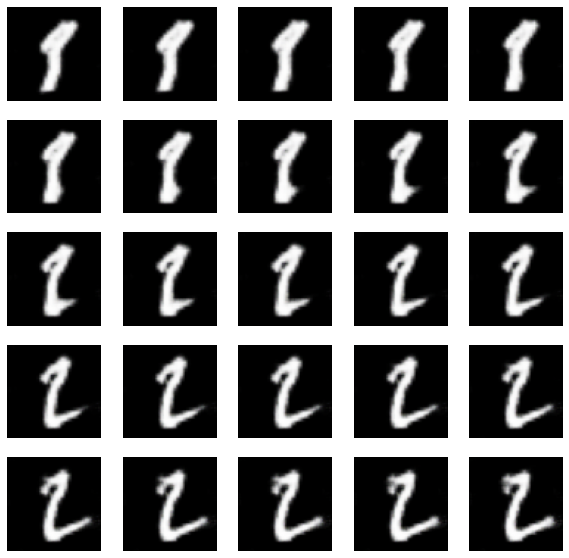

In [85]:
plot_across_latent(generator)

Again, We do not see a large difference, if any at all, between the generated images of the two GANs. Both produce striking strokes. With a couple more epochs, we believe those digits would be indistinguishable from the original dataset. 

## Dandelions

In [99]:
lfw_url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
data_path = 'flower_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)
        

img_list = []
data_path = 'flower_dataset/flower_photos/dandelion'
for path, _, fnames in os.walk(data_path):
      for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img)
            img_arr, _ = transform(img_arr)
            img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)      

Exception ignored in: <function NDArrayBase.__del__ at 0x7f5ec772add0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/mxnet/_ctypes/ndarray.py", line 58, in __del__
    check_call(_LIB.MXNDArrayFree(self.handle))
AttributeError: handle


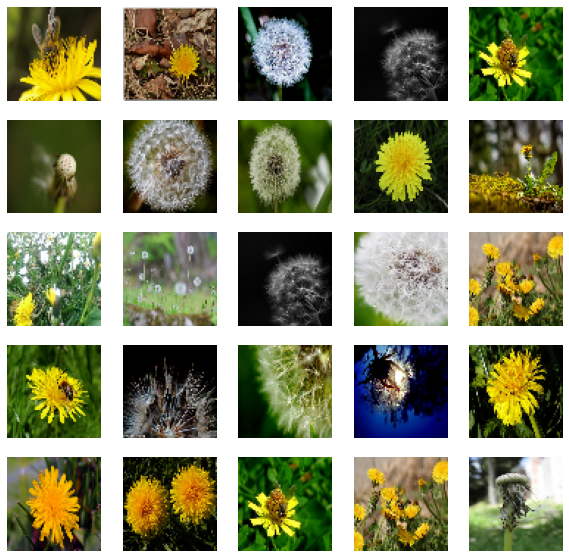

In [100]:
plot_real(img_list)

In [ ]:
generator, discriminator, trainerG, trainerD = initialize(False)
train_DCGAN(train_data, generator, discriminator, trainerG, trainerD, epochs=1000)

In [105]:
# Saving the network parameters
generator.save_parameters('DCGAN_generator_dandelion.params')
discriminator.save_parameters('DCGAN_discriminator_dandelion.params')

In [106]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=False)
generator.load_parameters('DCGAN_generator_dandelion.params')
discriminator.load_parameters('DCGAN_discriminator_dandelion.params')

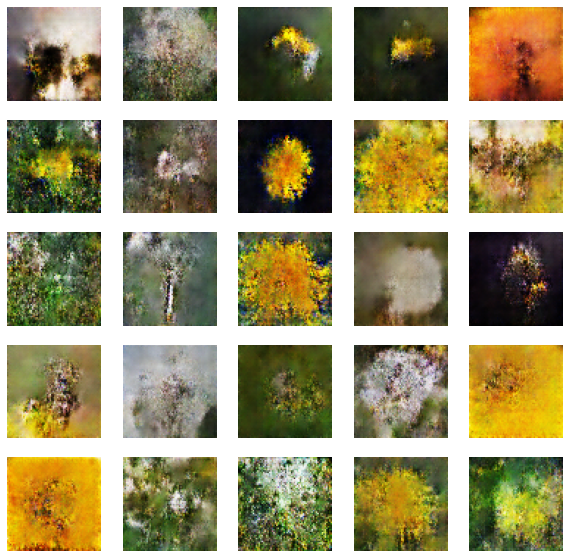

In [107]:
plot_some_fakes(generator)

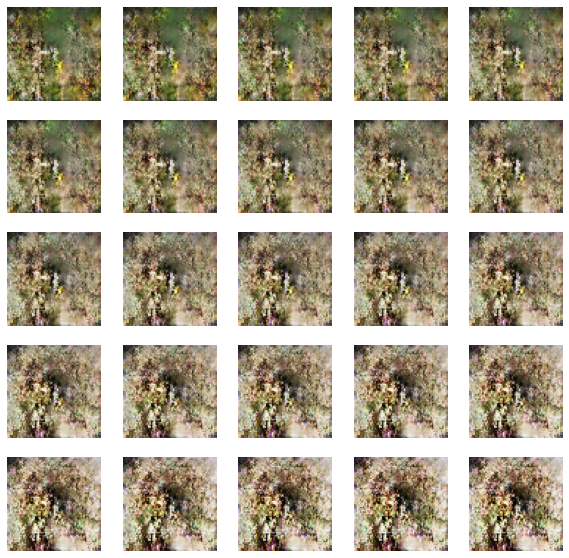

In [108]:
plot_across_latent(generator)

In [ ]:
generator, discriminator, trainerG, trainerD = initialize(True)
train_WGAN(train_data, generator, discriminator, trainerG, trainerD, epochs=100)

In [ ]:
# Saving the network parameters
generator.save_parameters('WGAN_generator_dandelion.params')
discriminator.save_parameters('WGAN_discriminator_dandelion.params')

In [109]:
# Loading parameters
generator, discriminator, trainerG, trainerD = initialize(wgan=True)
generator.load_parameters('WGAN_generator_dandelion.params')
discriminator.load_parameters('WGAN_discriminator_dandelion.params')

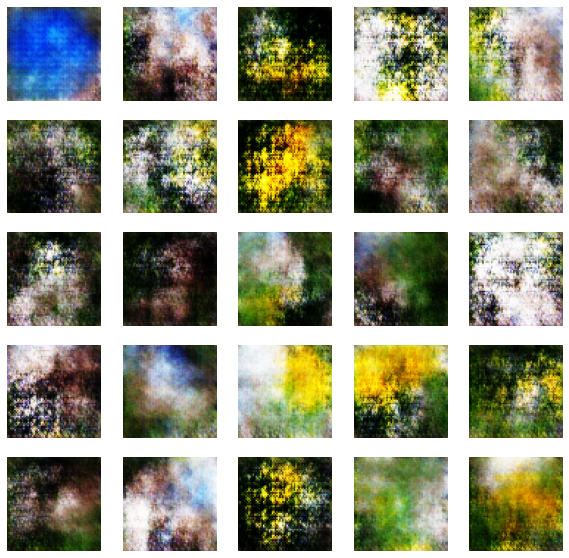

In [110]:
plot_some_fakes(generator)

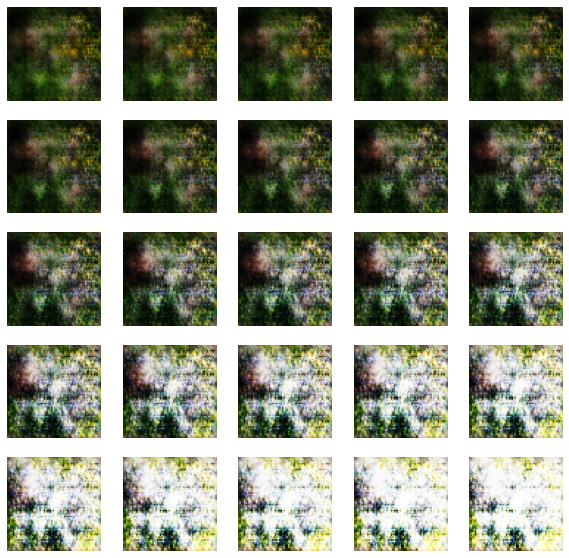

In [111]:
plot_across_latent(generator)

Now here we do see a large difference in the produced images. The DCGAN is becoming quite good at producing flower-like images. With some fine tuning, the generated images could become quite convincing. To be fair, we ran the DCGAN with a 1000 epochs because after 100, it didn't have much to show for. The WGAN was run with a 100 epochs because it simply is much slower. This is of course because of the inner loop ration of 5:1 in which the critic is trying to converge. In any case, the WGAN too produces quite interesting results and one can already suspect what it would look like with longer running times.